In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer,confusion_matrix, ConfusionMatrixDisplay
from scipy.optimize import minimize
import autosklearn.classification
import autosklearn.metrics
from tqdm import tqdm
from joblib import Parallel, delayed, dump, load
import m2cgen as m2c
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load data
df1 = pd.read_pickle("../exercises/features.pkl")

# Extract features and target
X = df1.drop(columns=['activity', 'participantId'])
y = df1['activity']

# Split the dataset
train, test = train_test_split(df1, test_size=0.3, stratify=df1[['activity', 'participantId']])
groups = train['participantId']

# Ready the features
X_train = train.drop(columns=['activity', 'participantId'])
y_train = train['activity']
X_test = test.drop(columns=['activity', 'participantId'])
y_test = test['activity']
y_train = y_train.values

# Define a model to optimize
model = DecisionTreeClassifier(random_state=0)

# Define the cross-validation strategy
logo = LeaveOneGroupOut()

In [5]:
X_test

,acceleration.y.var,acceleration.y.min,acceleration.z.var,accelerationIncludingGravity.x.mean,accelerationIncludingGravity.x.median,accelerationIncludingGravity.y.mean,accelerationIncludingGravity.y.var,accelerationIncludingGravity.y.min,accelerationIncludingGravity.y.max,accelerationIncludingGravity.y.median,accelerationIncludingGravity.z.var,accelerationIncludingGravity.z.min,accelerationIncludingGravity.z.max,accelerationIncludingGravity.z.median,rotationRate.alpha.var,rotationRate.alpha.min,rotationRate.beta.var,rotationRate.beta.max,rotationRate.gamma.var
99908,1.708469,-1.88,5.447657,0.535600,0.07,4.991333,1.572163,3.050000,7.03,4.94,5.770482,4.250000,13.35,7.78,479.412642,-41.259998,848.077255,81.790001,912.430523
110331,37.416440,-18.50,24.911217,-4.208333,-3.95,-10.163333,35.345072,-27.299999,1.00,-10.55,16.864438,-17.299999,7.80,0.05,8480.470419,-246.199997,14825.530509,254.899994,4098.103098
115727,0.001726,-0.10,0.007737,-0.613333,-0.60,4.091667,0.004167,4.000000,4.20,4.10,0.008870,8.600000,9.00,8.80,1.451017,-2.400000,1.517345,3.200000,2.902023
95358,0.549660,-2.45,0.291581,-1.008974,-1.06,5.392820,0.576821,3.660000,7.38,5.37,0.377734,6.590000,9.13,8.25,273.434480,-57.790001,459.931520,27.910000,187.952812
26419,0.017345,-0.10,0.154904,0.290000,0.30,3.820000,0.020949,3.600000,4.30,3.80,0.173590,7.800000,9.60,9.05,22.700904,-10.900000,47.683965,21.400000,13.851285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36380,0.154946,-1.10,0.089616,2.030000,1.90,-9.565000,0.206381,-10.700000,-8.50,-9.60,1.131797,-2.200000,1.10,-1.30,352.336641,-47.099998,95.082314,19.299999,146.111627
102360,2.219154,-2.69,4.516326,0.532267,0.28,5.146533,1.935999,2.720000,7.66,4.95,4.752314,4.730000,12.98,8.49,659.155730,-59.889999,691.800278,45.330002,672.962675
117006,5.655082,-6.60,3.828167,4.956667,5.10,4.458333,5.086540,-1.300000,11.30,4.05,3.889593,2.000000,12.10,7.15,460.089931,-45.500000,803.637722,82.400002,703.283426
84696,0.000000,0.00,0.010946,0.123333,0.10,6.083333,0.001412,6.000000,6.10,6.10,0.013887,7.400000,7.90,7.60,5.792234,-4.800000,0.175525,1.000000,0.318260


In [ ]:
# Define the function for cross-validation with groups
def cross_val_score_with_group(model, X, y, groups):
    logo = LeaveOneGroupOut()
    return cross_val_score(model, X, y, cv=logo.split(X, y, groups=groups), scoring=make_scorer(accuracy_score))
   #return cross_val_score(model, X, y, cv=GroupKFold(n_splits=10), groups=groups, scoring="f1_macro").mean()

# Define the objective function for Bayesian Optimization
def objective(params):
    max_depth, max_features = params
    model.set_params(max_depth=int(max_depth), max_features=max_features)
    scores = cross_val_score_with_group(model, X_train, y_train, groups)
    return -np.mean(scores)

# Define the parameter space
param_space = [
    (1, 15),        # max_depth
    (0.1, 1.0)      # max_features (as a fraction of the number of features)
]

# Use Gaussian Process for Bayesian Optimization
def bayesian_optimization(param_space, n_iters=10):  # Increased iterations
    kernel = Matern(nu=2.5)
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
    bounds = np.array([param_space[0], param_space[1]])

    # Initial random points
    x0 = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(5, bounds.shape[0]))
    initial_points = x0

    # Parallelize initial points evaluation
    y0 = Parallel(n_jobs=-1)(delayed(objective)((max_depth, max_features)) for max_depth, max_features in tqdm(initial_points, desc="Initial points evaluation"))

    y0 = np.array(y0)

    # Fit the model
    gpr.fit(x0, y0)

    # Perform optimization
    for i in tqdm(range(n_iters), desc="Bayesian Optimization iterations"):
        x_next = minimize(lambda x: gpr.predict([x])[0], bounds.mean(axis=1), bounds=bounds).x
        y_next = objective(x_next)
        x0 = np.vstack((x0, x_next))
        y0 = np.append(y0, y_next)
        gpr.fit(x0, y0)

    best_idx = np.argmin(y0)
    return x0[best_idx], y0[best_idx]

# Run Bayesian Optimization
best_params, best_score = bayesian_optimization(param_space)

# Print the best parameters and score
print("Best parameters:", best_params)
print("Best cross-validation score:", -best_score)



Bayesian Optimization iterations:  30%|███       | 3/10 [00:06<00:15,  2.23s/it]

In [3]:
# Evaluate the model with the best parameters on the test set
model.set_params(max_depth=int(best_params[0]), max_features=best_params[1])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_score = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Test score with Bayesian Optimization:")
print(f"Accuracy: {test_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Test score with Bayesian Optimization:
Accuracy: 0.957006631227051
Precision: 0.9572663458587409
Recall: 0.957006631227051
F1 Score: 0.9568190937894402


In [4]:
# Save the model
print(model.n_features_in_)
model_filename = 'experiment19.joblib'
dump(model, model_filename)

# Load the model
loaded_model = load(model_filename)
print(loaded_model.n_features_in_)

# Convert the model to JavaScript using m2cgen
js_code = m2c.export_to_javascript(loaded_model)
with open("experiment19.js", "w") as file:
    file.write(js_code)

print("Model saved and converted to JavaScript successfully.")

19
19
Model saved and converted to JavaScript successfully.


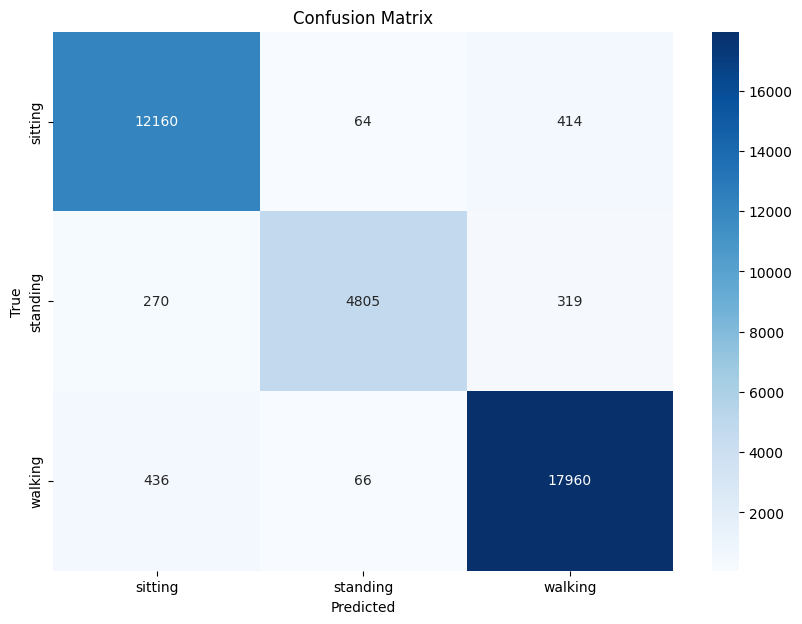

In [5]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [6]:
# Serialize the attributes of a RobustScaler instance into a dictionary.
scaler_serialized = {"scale": list(scaler.scale_), "center": list(scaler.center_), "name": RobustScaler.__name__}
print(scaler_serialized)

{'scale': [9.693765900939809, 7.599999807775021, 10.003263761258193, 4.686666676308959, 4.109999895095825, 11.542413245633155, 7.084130062825866, 15.25, 6.6000001430511475, 10.950000047683716, 10.074989173841468, 16.499999523162842, 6.950000286102295, 8.499999821186066, 4705.152937125953, 144.10000610351562, 4315.272268924179, 138.2999939918518, 3456.4980204109643], 'center': [0.3434727490087117, -1.3600000143051147, 0.41086451707852595, 0.05766355091375168, 0.05999999865889549, -0.09089108947480079, 0.33093080057398677, -2.299999952316284, 0.07000000029802322, -0.09000000357627869, 0.5102076380405751, 3.5199999809265137, 9.850000381469727, 3.940000057220459, 189.50850075356664, -26.799999237060547, 241.94135064299974, 30.940000534057617, 181.16240410357352], 'name': 'RobustScaler'}


In [ ]:
# Define the GroupKFold cross-validation strategy for Auto-sklearn
group_kfold = GroupKFold(n_splits=10)

# Auto-sklearn setup with GroupKFold
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=300,
    per_run_time_limit=60,
    resampling_strategy=group_kfold,
    resampling_strategy_arguments={'groups': groups},
    memory_limit=20000,
    n_jobs=-1,

)

# Fit the Auto-sklearn model with the groups parameter
automl.fit(X_train, y_train, dataset_name='activity')
automl.refit(X_train, y_train)

# Evaluate the Auto-sklearn model on the test set
automl_predictions = automl.predict(X_test)
automl_test_score = accuracy_score(y_test, automl_predictions)
automl_precision = precision_score(y_test, automl_predictions, average='weighted')
automl_recall = recall_score(y_test, automl_predictions, average='weighted')
automl_f1 = f1_score(y_test, automl_predictions, average='weighted')

print("Test score with Auto-Sklearn:")
print(f"Accuracy: {automl_test_score}")
print(f"Precision: {automl_precision}")
print(f"Recall: {automl_recall}")
print(f"F1 Score: {automl_f1}")

[WARNING] [2024-07-21 17:43:08,240:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-07-21 17:43:09,122:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-07-21 17:43:10,113:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-07-21 17:44:07,288:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-07-21 17:44:07,594:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-07-21 17:44:08,005:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-07-21 17:44:08,286:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-07-21 17:44:08,666:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-07-21 17:44:09,305:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-07-21 17:44: